## 0 - 250 Hz

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [2]:
dataset = np.load('data/database_1_fft.npz')

In [3]:
random_state = 420

X_train, X_test, y_train, y_test = train_test_split(dataset['fourier'], dataset['label'], test_size=0.2, stratify=dataset['label'], random_state=random_state)

In [10]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import joblib

skf = StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True)

svc_250 = SVC(random_state=random_state, verbose=2, class_weight='balanced')
pca_250 = PCA(n_components=50, random_state=random_state)

svm_250_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('pca', pca_250),
    ('classifier', svc_250)
])

In [11]:
with joblib.parallel_backend('loky', n_jobs=8):
    svm_250_score = cross_val_score(svm_250_pipeline, X_train, y_train, cv=skf, scoring='balanced_accuracy', verbose=2)
    svm_250_pipeline.fit(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:  4.4min remaining:  6.6min
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:  4.6min finished


[LibSVM]

In [12]:
print(f'Test score: {svm_250_score.mean() : .2f} ({svm_250_score.std() : .2f})')
y_250_pred = svm_250_pipeline.predict(X_test)
print(classification_report(y_test, y_250_pred))

Test score:  0.76 ( 0.01)
              precision    recall  f1-score   support

           0       0.30      0.83      0.44      1182
           1       0.96      0.70      0.81      7849

    accuracy                           0.72      9031
   macro avg       0.63      0.77      0.63      9031
weighted avg       0.88      0.72      0.76      9031



In [14]:
from imblearn.ensemble import BalancedRandomForestClassifier

brfc_250 = BalancedRandomForestClassifier(random_state=random_state, verbose=1, class_weight='balanced')

brfc_250_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('pca', pca_250),
    ('classifier', brfc_250)
])

In [15]:
with joblib.parallel_backend('loky', n_jobs=6):
    brfc_250_score = cross_val_score(brfc_250_pipeline, X_train, y_train, cv=skf, scoring='balanced_accuracy', verbose=2)
    brfc_250_pipeline.fit(X_train, y_train)
    
print(f'Test score: {brfc_250_score.mean() : .2f} ({brfc_250_score.std() : .2f})')
y_brfc_250_pred = brfc_250_pipeline.predict(X_test)
print(classification_report(y_test, y_brfc_250_pred))

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   5 | elapsed:  4.0min remaining:  2.7min
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:  4.1min finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.6s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    3.9s finished


Test score:  0.81 ( 0.01)
              precision    recall  f1-score   support

           0       0.54      0.73      0.62      1182
           1       0.96      0.90      0.93      7849

    accuracy                           0.88      9031
   macro avg       0.75      0.82      0.77      9031
weighted avg       0.90      0.88      0.89      9031



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


---

## 0 - 100 Hz

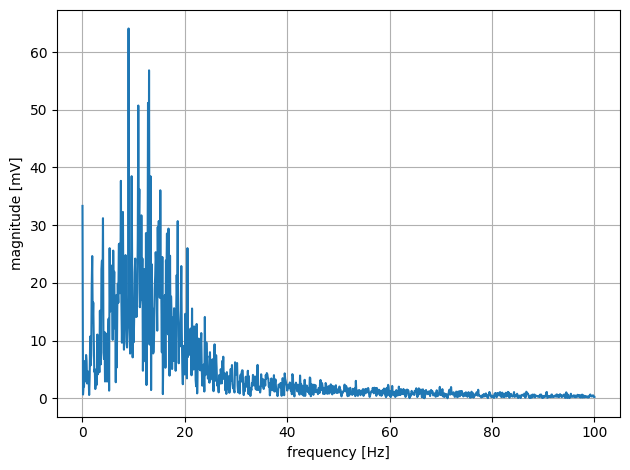

In [23]:
signal = dataset['fourier'][0]
N = len(signal)
fs = 500

freqs = np.fft.fftfreq(N, 1 / fs)
positive_freqs = freqs[: N // 2]
mag_values = signal[: N // 2]

mask_100hz = positive_freqs <= 100
filtered_freqs = positive_freqs[mask_100hz]
filtered_mag_values = mag_values[mask_100hz]

plt.plot(filtered_freqs, filtered_mag_values, label='Magnitude')
plt.xlabel('frequency [Hz]')
plt.ylabel('magnitude [mV]')
plt.grid()
plt.tight_layout()

In [ ]:
from sklearn.model_selection import train_test_split

y = dataset['label']
X_mag_fft = dataset['fourier'][: N // 2]
X_mag_fft = X_mag_fft[:, mask_100hz]

random_state = 420

X_train, X_test, y_train, y_test = train_test_split(X_mag_fft, y, test_size=0.2, stratify=y, random_state=420)

### BalancedRandomForest

In [6]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pca = PCA(n_components=50, random_state=random_state)
clf = BalancedRandomForestClassifier(n_estimators=100, random_state=random_state, n_jobs=os.cpu_count() - 2, verbose=2)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('pca', pca),
    ('classifier', clf)
])

param_grid = {
    'pca__n_components': [60, 80, 100, 120, 140],
    'classifier__n_estimators': [60, 80, 100, 120, 140, 160, 180, 200]
}

In [ ]:
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=skf, scoring='balanced_accuracy', n_jobs=os.cpu_count() - 2, verbose=2)
grid_search.fit(X_train, y_train)

In [8]:
import joblib

joblib.dump(grid_search.best_estimator_, 'models/BRFC_PCA.pkl')

['models/BRFC_PCA.pkl']

In [10]:
print(f'Best parameters: {grid_search.best_params_}')

Best parameters: {'classifier__n_estimators': 180, 'pca__n_components': 60}


In [ ]:
import joblib
from sklearn.model_selection import cross_val_score, StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# best_model = grid_search.best_estimator_
best_model = joblib.load('models/BRFC_PCA.pkl')
cv_score = cross_val_score(best_model, X_train, y_train, cv=skf, scoring='balanced_accuracy', n_jobs=os.cpu_count() - 2, verbose=2)
y_pred = best_model.predict(X_test)

In [17]:
print(f'Test score: {cv_score.mean() : .2f} ({cv_score.std() : .2f})')
print(classification_report(y_test, y_pred))

Test score:  0.87 ( 0.00)
              precision    recall  f1-score   support

           0       0.59      0.84      0.69      1182
           1       0.97      0.91      0.94      7849

    accuracy                           0.90      9031
   macro avg       0.78      0.88      0.82      9031
weighted avg       0.92      0.90      0.91      9031



### SVM

In [32]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import joblib

random_state = 420

svc_500 = SVC(random_state=random_state, verbose=2, class_weight='balanced')
pca_500 = PCA(n_components=50, random_state=random_state)
scaler = StandardScaler()

svm_500_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('pca', pca_500),
    ('classifier', svc_500)
])

In [33]:
with joblib.parallel_backend('loky', n_jobs=10):
    # svm_500_score = cross_val_score(svm_500_pipeline, X_train, y_train, cv=skf, scoring='balanced_accuracy', verbose=2)
    svm_500_pipeline.fit(X_train, y_train)

[LibSVM]

In [34]:
with joblib.parallel_backend('loky', n_jobs=6):
    svm_500_score = cross_val_score(svm_500_pipeline,
                                    X_train,
                                    y_train,
                                    cv=skf,
                                    scoring='balanced_accuracy',
                                    verbose=1)
y_500_pred = svm_500_pipeline.predict(X_test)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:  3.3min finished


In [35]:
print(f'SVM balanced accuracy score: {svm_500_score.mean() : .2f} ({svm_500_score.std() : .2f})')
print(classification_report(y_test, y_500_pred))

SVM balanced accuracy score:  0.76 ( 0.01)
              precision    recall  f1-score   support

           0       0.30      0.83      0.44      1182
           1       0.96      0.70      0.81      7849

    accuracy                           0.72      9031
   macro avg       0.63      0.77      0.63      9031
weighted avg       0.88      0.72      0.76      9031



---

### fs = 240 -> denoised signal downsampling test

In [7]:
from scipy.signal import resample

target_fs = 240
duration_s = 10
target_n_samples = target_fs * duration_s
ecg_downsampled = resample(dataset['ecg'], target_n_samples, axis=1)

print(ecg_downsampled.shape)

(45152, 2400)


In [41]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from scipy.stats import uniform, randint

random_state = 420

# svc = SVC(random_state=random_state)
# pca = PCA(n_components=50, random_state=random_state)
scaler = StandardScaler()

param_distributions = {
    'pca__n_components': randint(50, 200),
    'classifier__C': uniform(0.1, 10),
    'classifier__gamma': uniform(0.001, 1),
    'classifier__kernel': ['rbf']
}

svm_pipeline = Pipeline([
    ('scale', scaler),
    ('pca', PCA()),
    ('classifier', SVC())
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

##### Randomized param search

In [ ]:
rand_search = RandomizedSearchCV(
    svm_pipeline,
    param_distributions,
    n_iter=20,
    scoring='balanced_accuracy',
    cv=skf,
    verbose=2,
    random_state=random_state,
    n_jobs=os.cpu_count() - 2
)

rand_search.fit(X_train, y_train)

In [ ]:
print('Best params', rand_search.best_params_)
print('Best balanced accuracy', rand_search.best_score_)

##### Normal pipeline

In [28]:
cv_score = cross_val_score(svm_pipeline, X_train, y_train, cv=skf, scoring='balanced_accuracy', verbose=1, n_jobs=os.cpu_count() - 4)
svm_pipeline.fit(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:   50.9s remaining:  1.3min
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:   52.3s finished


Pipeline(steps=[('scale', StandardScaler()),
                ('pca', PCA(n_components=50, random_state=420)),
                ('classifier', SVC(random_state=420))])

In [29]:
y_pred = svm_pipeline.predict(X_test)
print(f'Test score: {cv_score.mean() : .2f} ({cv_score.std() : .2f})')
print(classification_report(y_test, y_pred))

Test score:  0.59 ( 0.01)
              precision    recall  f1-score   support

           0       0.74      0.24      0.37      1182
           1       0.90      0.99      0.94      7849

    accuracy                           0.89      9031
   macro avg       0.82      0.61      0.65      9031
weighted avg       0.88      0.89      0.86      9031

